# Albeado Data Challenge

Yuyao Hu 11/11/2018

## Target:

    - Finish some exploration of the data
    - Fit some simple models
    - Summarize findings: 
        - Describing the data
        - Predict future car count
        
## Assumptions at the first galance:
**day of week** will influence the number of car in the parking lot

There might be some periodical pattern. (eg. More cars at weekends, less cars during national vacations.)

**weather value** and **cloud level** will affect the visibility of the parking lot. 

(This will decrease the number of car count in the data while the real number is not change.
        
## 0. Data Exploration
### 0.1 Read in dataset

In [1]:
import os
import pandas as pd
import numpy as np 
# print(pd.__version__)

path = "./data/"
filename_read = os.path.join(path, 'data.csv')
filename_write = os.path.join(path, 'output.csv')

df = pd.read_csv(filename_read)
df[0:5]

,date,day.of.week,car.count,weather,cloud.indicator
0,2010-01-01,Friday,101,0.1,clear
1,2010-01-02,Saturday,34,0.2,cloudy
2,2010-01-03,Sunday,113,0.4,clear
3,2010-01-04,Monday,5,0.6,cloudy
4,2010-01-05,Tuesday,124,0.1,clear


### 0.2 Preprocessing

#### 0.2.1 Useful functions
reference: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)

In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    # df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [3]:
# Split 'data' into 'Y(ear)', 'M(onth)', 'D(ay)'
df['Y'], df['M'], df['D'] = df['date'].str.split('-', 2).str
df['YM'] = df['date'].map(lambda x: str(x)[0:7])
yearMonth = df['YM'].unique()
df['MD'] = df['date'].map(lambda x: str(x)[5:10])
yearMonth = df['MD'].unique()

# transform cloud.indicator from text into num
# clear - 0
# cloudy - 1
df.replace('clear', 0, inplace = True)
df.replace('cloudy', 1, inplace = True)

#df.replace('Monday', 1, inplace = True)
#df.replace('Tuesday', 2, inplace = True)
#df.replace('Wednesday', 3, inplace = True)
#df.replace('Thursday', 4, inplace = True)
#df.replace('Friday', 5, inplace = True)
#df.replace('Saturday', 6, inplace = True)
#df.replace('Sunday', 7, inplace = True)

encode_text_dummy(df, 'day.of.week')
# encode_text_index(df, 'day.of.week')
df[0:5]

,date,day.of.week,car.count,weather,cloud.indicator,Y,M,D,YM,MD,day.of.week-Friday,day.of.week-Monday,day.of.week-Saturday,day.of.week-Sunday,day.of.week-Thursday,day.of.week-Tuesday,day.of.week-Wednesday
0,2010-01-01,Friday,101,0.1,0,2010,01,01,2010-01,01-01,1,0,0,0,0,0,0
1,2010-01-02,Saturday,34,0.2,1,2010,01,02,2010-01,01-02,0,0,1,0,0,0,0
2,2010-01-03,Sunday,113,0.4,0,2010,01,03,2010-01,01-03,0,0,0,1,0,0,0
3,2010-01-04,Monday,5,0.6,1,2010,01,04,2010-01,01-04,0,1,0,0,0,0,0
4,2010-01-05,Tuesday,124,0.1,0,2010,01,05,2010-01,01-05,0,0,0,0,0,1,0


Here, when dealing with the text categorical feature like **day.of.week**, typically we have 2 kinds of ways to transfrom them into numbers.

The first way as shown above is to transform it in to several columns using one hot encoding.

The other way, like the comment out lines before is to encode text into a series of numbers. 

For this day of week feature, it seems that both encoding are reasonable.

If we encode *Monday* as 1 and *Sunday* as 7, then we will get the average of Mon and Sun equals to Thursday. This will probably make a mess while at the same time there does exist some relationships for day of week as a time series.

One hot encoding can make the dataset become sparse since it will insert too many zeros into the dataset and incease the dimension of the problem.

(I tried both methods and the results are almost same to each other.

In [4]:
df2010 = df[df['Y'] == '2010']
df2011 = df[df['Y'] == '2011']
df2012 = df[df['Y'] == '2012']
df2013 = df[df['Y'] == '2013']
df2014 = df[df['Y'] == '2014']
df2015 = df[df['Y'] == '2015']
df2016 = df[df['Y'] == '2016']

In [5]:
weatherVal = df['weather'].unique()
print(len(weatherVal), min(weatherVal), max(weatherVal))
print(sorted(weatherVal))

66 -3.2 4.3
[-3.2, -3.1, -3.0, -2.9, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2.0, -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 3.0, 3.1, 3.2, 3.3, 3.8, 4.3]


In [6]:
cloudVal = df['cloud.indicator'].unique()
print(cloudVal)

[0 1]


In [7]:
dataCnt = len(df)
cloudCnt = len(df[df['cloud.indicator'] == 0])
clearCnt = len(df[df['cloud.indicator'] == 1])
print(dataCnt, cloudCnt, clearCnt)

2373 1353 1020


In [8]:
# Split the dataset into two parts based on the cloud indicator
cloudDF = df[df['cloud.indicator'] == 1]
clearDF = df[df['cloud.indicator'] == 0]

# Take an overview about how the cloud will affect the car count by computer the percentage.
clearAvg = clearDF['car.count'].mean()
cloudAvg = cloudDF['car.count'].mean()
pct = cloudAvg/clearAvg
print(clearAvg, cloudAvg, pct)

143.81152993348115 71.6029411764706 0.4978943010312869


### 0.3 Basic Explorations
#### 0.3.1 (hist) Distribution of car.count

49.4375 35.34821203045495


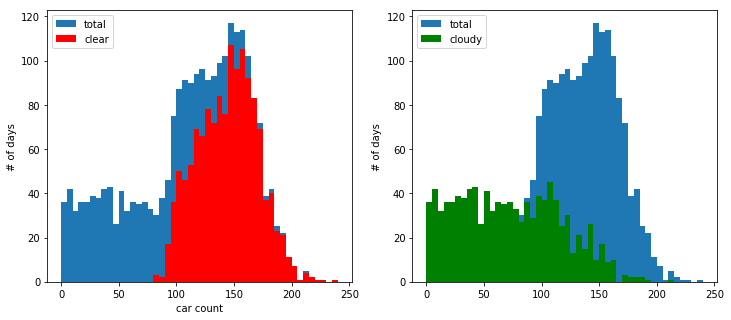

In [9]:
from matplotlib import pyplot as plt

binsize = 5
bins = [i for i in range(0, max(df['car.count']) + binsize, binsize)]
numCars, Days = np.histogram(df['car.count'], bins) 
avg = np.mean(numCars)
std = np.std(numCars)
print(avg, std)

plt.figure(1, figsize=(12, 5))
plt1 = plt.subplot(121)

num = plt.hist(df['car.count'], bins, label = 'total') 
clearNum = plt.hist(clearDF['car.count'], bins, color = 'r', label = 'clear')
# cloudNum = plt.hist(cloudDF['car.count'], bins, color = 'g', label = 'cloudy')

plt1.set_xlabel('car count')
plt1.set_ylabel('# of days')
plt1.legend(loc = 'upper left')

plt2 = plt.subplot(122)

num = plt.hist(df['car.count'], bins, label = 'total') 
# clearNum = plt.hist(clearDF['car.count'], bins, color = 'r', label = 'clear')
cloudNum = plt.hist(cloudDF['car.count'], bins, color = 'g', label = 'cloudy')

# plt2.set_xlabel('car count')
plt2.set_ylabel('# of days')
plt2.legend(loc = 'upper left')

plt.show()

It shows that the cloud level does have a big impact on the number of cars.

#### 0.3.2 (Line chart) date - num

Draw a line chart to see if there is a periodical distribution of the number of cars.

Since there are ~2400 lines of data in the dataset, we draw the first month instead.

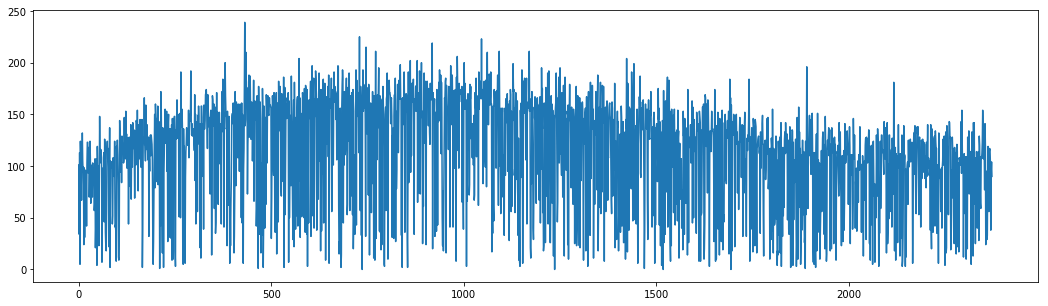

In [10]:
plt.figure(1, figsize=(18, 5))
plt.plot(df['car.count'])

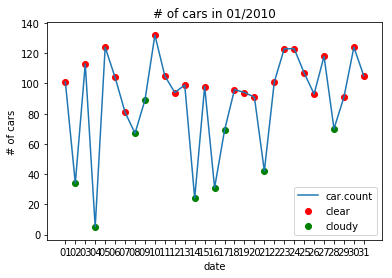

In [11]:
# plt.plot(df['date'], df['car.count'])
df1 = df[0:31]
df1clear = df1[df1['cloud.indicator'].isin(['0'])]
df1cloud = df1[df1['cloud.indicator'].isin(['1'])]

plt.plot(df1['D'], df1['car.count'])
clear = plt.scatter(df1clear['D'], df1clear['car.count'], c = 'r', label = 'clear')
cloud = plt.scatter(df1cloud['D'], df1cloud['car.count'], c = 'g', label = 'cloudy')

plt.legend(loc = 'lower right')
plt.xlabel('date')
plt.ylabel('# of cars')
plt.title('# of cars in 01/2010')
plt.show()

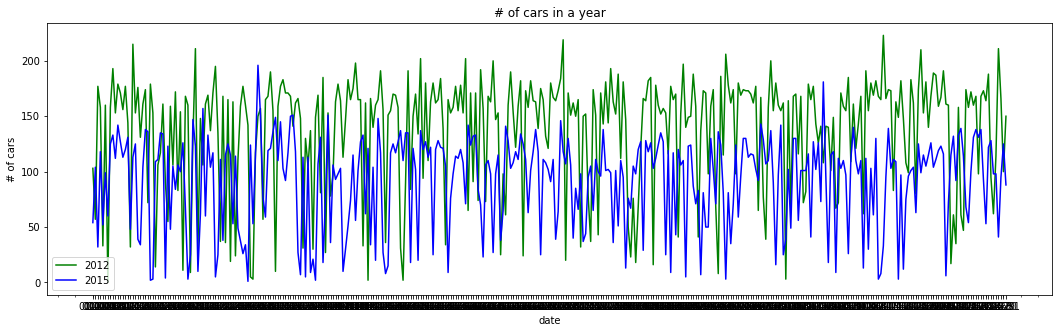

In [12]:
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
# ax.xaxis.set_major_formatter(FuncFormatter(myfunc)) 
plt.figure(1, figsize=(18, 5))
#plt.plot(df2010['MD'], df2010['car.count'], c = 'Yellow', label = '2010')
#plt.plot(df2011['MD'], df2011['car.count'], c = 'Lime', label = '2011')
plt.plot(df2012['MD'], df2012['car.count'], c = 'Green', label = '2012')
#plt.plot(df2013['MD'], df2013['car.count'], c = 'Aqua', label = '2013')
#plt.plot(df2014['MD'], df2014['car.count'], c = 'Teal', label = '2014')
plt.plot(df2015['MD'], df2015['car.count'], c = 'Blue', label = '2015')
# plt.plot(df2016['car.count'], c = 'Navy', label = '2016')

plt.legend(loc = 'lower left')
plt.xlabel('date')
plt.ylabel('# of cars')
plt.title('# of cars in a year')

ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(7))

It turns out that the weather do have a strong impact on the number of seen cars. So we have to take 'cloud indicator' into consideration.

By ploting the above figures, I tried to find some periodical information and some tendency in the dataset. I want to know if there have some pattern like there are more cars in the weekends or if there is a significant increasing during the thanks giving vacations.

From the data shown above, it seems that there is no clear periodical tendency could be show from the plots above.
This may cause by the influence of the weather condition, the time the car.count data were collected each day...

After that I will try to find the realtionship among _weather value_, _cloud level_, _car num_ by plotting a scatter plot. 

#### 0.3.3 (scatter plot) weather value, cloud indicator - num

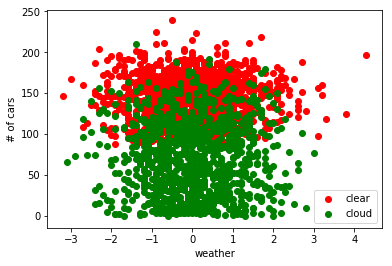

In [13]:
plt.scatter(clearDF['weather'], clearDF['car.count'], c = 'r', label = 'clear')
plt.scatter(cloudDF['weather'], cloudDF['car.count'], c = 'g', label = 'cloud')

plt.legend(loc = 'lower right')
plt.xlabel('weather')
plt.ylabel('# of cars')
plt.show()

At this point, I didn't see any clear affect of the value of the _weather_ column. 

To dive into this feature, more detailed background knowledge may needed.
We probably will need more information about them, like how the values come from to help us interpret the values better.
For the following analysis, we will first omit this feature.

### 0.4 More exploration based on cloud/clear

#### 0.4.1 day of week - num

If there are more cars in the parking lot at weekends compared to weekdays?

In [14]:
week = df['day.of.week'].unique()
AvgWeek = []
clearAvgWeek = []
cloudAvgWeek = []
clearAvgWeekPct = []

for i in range(len(week)):
    AvgWeek.append(df[df['day.of.week'] == week[i]]['car.count'].mean())
    clearAvgWeek.append(clearDF[clearDF['day.of.week'] == week[i]]['car.count'].mean())
    clearAvgWeekPct.append(clearAvgWeek[i] * pct)
    cloudAvgWeek.append(cloudDF[cloudDF['day.of.week'] == week[i]]['car.count'].mean())

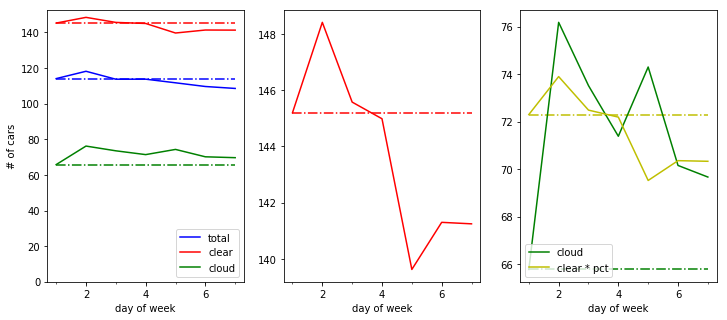

In [15]:
from matplotlib.ticker import MultipleLocator

plt.figure(1, figsize=(12, 5))
both = plt.subplot(131)
both.plot([i for i in range(1, 8)], AvgWeek, c = 'b', label = 'total')
both.plot([i for i in range(1, 8)], clearAvgWeek, c = 'r', label = 'clear')
both.plot([i for i in range(1, 8)], cloudAvgWeek, c = 'g', label = 'cloud')
both.hlines(AvgWeek[0], 1, 7, color = 'b', linestyles='dashdot')
both.hlines(clearAvgWeek[0], 1, 7, color = 'r', linestyles='dashdot')
both.hlines(cloudAvgWeek[0], 1, 7, color = 'g', linestyles='dashdot')
both.legend(loc = 'lower right')
both.set_ylim(ymin = 0)

clear = plt.subplot(132)
clear.plot([i for i in range(1, 8)], clearAvgWeek, c = 'r', label = 'clear')
clear.hlines(clearAvgWeek[0], 1, 7, color = 'r', linestyles='dashdot')

cloud = plt.subplot(133)
cloud.plot([i for i in range(1, 8)], cloudAvgWeek, c = 'g', label = 'cloud')
cloud.hlines(cloudAvgWeek[0], 1, 7, color = 'g', linestyles='dashdot')
cloud.plot([i for i in range(1, 8)], clearAvgWeekPct, c = 'y', label = 'clear * pct')
cloud.hlines(clearAvgWeekPct[0], 1, 7, color = 'y', linestyles='dashdot')
cloud.legend(loc = 'lower left')

both.xaxis.set_minor_locator(MultipleLocator(1))
both.set_xlabel('day of week')
both.set_ylabel('# of cars')
clear.xaxis.set_minor_locator(MultipleLocator(1))
clear.set_xlabel('day of week')
cloud.xaxis.set_minor_locator(MultipleLocator(1))
cloud.set_xlabel('day of week')

plt.show()

It seem that the number of cars in the parking lot on Saturdays and Sundays are relatively smaller than the rest days in a week. If the data comes from the parking lot of outside an office, it sounds quite reasonable that people are more likely to stay at home to enjoy their weekends.

To see how the cloudy weather impact the number, I draw the number of clear days multiplied by the percentage on average and draw it with the line chart of the cloud data. (To see if they share some same tendencies.)

The average number of cars for each day in the plot(blue line) is closer to the red line(clear days), this is because there are more clear days in the dataset.

#### 0.4.2 month - num

( I should have packed this part as a function...

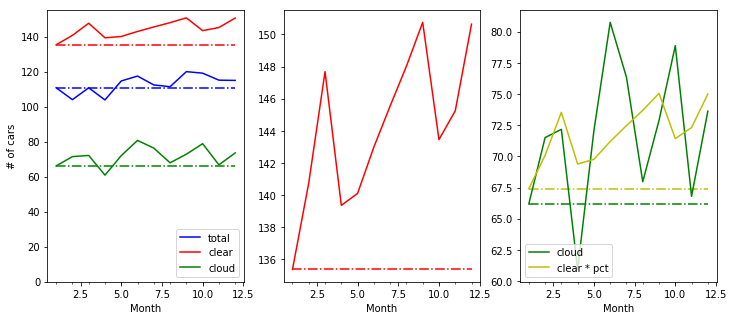

In [16]:
month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
AvgM = []
clearAvgM = []
cloudAvgM = []
clearAvgMPct = []

for i in range(len(month)):
    AvgM.append(df[df['M'] == month[i]]['car.count'].mean())
    clearAvgM.append(clearDF[clearDF['M'] == month[i]]['car.count'].mean())
    cloudAvgM.append(cloudDF[cloudDF['M'] == month[i]]['car.count'].mean())
    clearAvgMPct.append(clearAvgM[i] * pct)
    
plt.figure(1, figsize=(12, 5))
both = plt.subplot(131)
both.plot([i for i in range(1, 13)], AvgM, c = 'b', label = 'total')
both.plot([i for i in range(1, 13)], clearAvgM, c = 'r', label = 'clear')
both.plot([i for i in range(1, 13)], cloudAvgM, c = 'g', label = 'cloud')
both.hlines(AvgM[0], 1, 12, color = 'b', linestyles='dashdot')
both.hlines(clearAvgM[0], 1, 12, color = 'r', linestyles='dashdot')
both.hlines(cloudAvgM[0], 1, 12, color = 'g', linestyles='dashdot')
both.legend(loc = 'lower right')
both.set_ylim(ymin = 0)

clear = plt.subplot(132)
clear.plot([i for i in range(1, 13)], clearAvgM, c = 'r', label = 'clear')
clear.hlines(clearAvgM[0], 1, 12, color = 'r', linestyles='dashdot')

cloud = plt.subplot(133)
cloud.plot([i for i in range(1, 13)], cloudAvgM, c = 'g', label = 'cloud')
cloud.hlines(cloudAvgM[0], 1, 12, color = 'g', linestyles='dashdot')
cloud.plot([i for i in range(1, 13)], clearAvgMPct, c = 'y', label = 'clear * pct')
cloud.hlines(clearAvgMPct[0], 1, 12, color = 'y', linestyles='dashdot')
cloud.legend(loc = 'lower left')

both.xaxis.set_minor_locator(MultipleLocator(1))
both.set_xlabel('Month')
both.set_ylabel('# of cars')
clear.xaxis.set_minor_locator(MultipleLocator(1))
clear.set_xlabel('Month')
cloud.xaxis.set_minor_locator(MultipleLocator(1))
cloud.set_xlabel('Month')

plt.show()   

#### 0.4.3 year - num

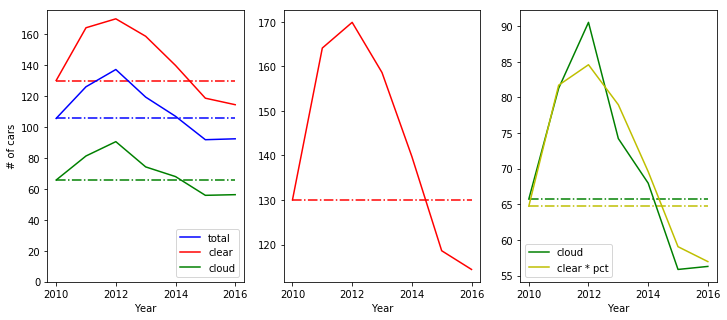

In [17]:
year = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
AvgY = []
clearAvgY = []
cloudAvgY = []
clearAvgYPct = []

for i in range(len(year)):
    AvgY.append(df[df['Y'] == year[i]]['car.count'].mean())
    clearAvgY.append(clearDF[clearDF['Y'] == year[i]]['car.count'].mean())
    cloudAvgY.append(cloudDF[cloudDF['Y'] == year[i]]['car.count'].mean())
    clearAvgYPct.append(clearAvgY[i] * pct)
    
plt.figure(1, figsize=(12, 5))
both = plt.subplot(131)
both.plot([i for i in range(2010, 2017)], AvgY, c = 'b', label = 'total')
both.plot([i for i in range(2010, 2017)], clearAvgY, c = 'r', label = 'clear')
both.plot([i for i in range(2010, 2017)], cloudAvgY, c = 'g', label = 'cloud')
both.hlines(AvgY[0], 2010, 2016, color = 'b', linestyles='dashdot')
both.hlines(clearAvgY[0], 2010, 2016, color = 'r', linestyles='dashdot')
both.hlines(cloudAvgY[0], 2010, 2016, color = 'g', linestyles='dashdot')
both.legend(loc = 'lower right')
both.set_ylim(ymin = 0)

clear = plt.subplot(132)
clear.plot([i for i in range(2010, 2017)], clearAvgY, c = 'r', label = 'clear')
clear.hlines(clearAvgY[0], 2010, 2016, color = 'r', linestyles='dashdot')

cloud = plt.subplot(133)
cloud.plot([i for i in range(2010, 2017)], cloudAvgY, c = 'g', label = 'cloud')
cloud.hlines(cloudAvgY[0], 2010, 2016, color = 'g', linestyles='dashdot')
cloud.plot([i for i in range(2010, 2017)], clearAvgYPct, c = 'y', label = 'clear * pct')
cloud.hlines(clearAvgYPct[0], 2010, 2016, color = 'y', linestyles='dashdot')
cloud.legend(loc = 'lower left')

# both.xaxis.set_minor_locator(MultipleLocator(1))
both.set_xlabel('Year')
both.set_ylabel('# of cars')
# clear.xaxis.set_minor_locator(MultipleLocator(1))
clear.set_xlabel('Year')
# cloud.xaxis.set_minor_locator(MultipleLocator(1))
cloud.set_xlabel('Year')

plt.show()   

In this set of plots, we see the closest trend in both cloudy and clear days.

#### 0.4.4 year, month - num

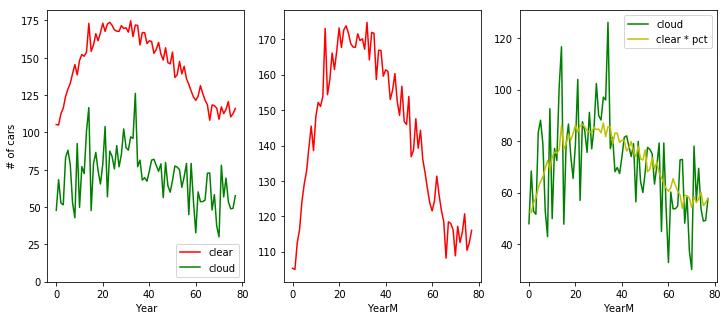

In [18]:
yearMonth = df['YM'].unique()
clearAvgYM = []
cloudAvgYM = []
clearAvgYMPct = []

for i in range(len(yearMonth)):
    clearAvgYM.append(clearDF[clearDF['YM'] == yearMonth[i]]['car.count'].mean())
    cloudAvgYM.append(cloudDF[cloudDF['YM'] == yearMonth[i]]['car.count'].mean())
    clearAvgYMPct.append(clearAvgYM[i] * pct)
    
plt.figure(1, figsize=(12, 5))
both = plt.subplot(131)
both.plot([i for i in range(len(yearMonth))], clearAvgYM, c = 'r', label = 'clear')
both.plot([i for i in range(len(yearMonth))], cloudAvgYM, c = 'g', label = 'cloud')
both.legend(loc = 'lower right')
both.set_ylim(ymin = 0)

clear = plt.subplot(132)
clear.plot([i for i in range(len(yearMonth))], clearAvgYM, c = 'r', label = 'clear')

cloud = plt.subplot(133)
cloud.plot([i for i in range(len(yearMonth))], cloudAvgYM, c = 'g', label = 'cloud')
cloud.plot([i for i in range(len(yearMonth))], clearAvgYMPct, c = 'y', label = 'clear * pct')
cloud.legend(loc = 'upper right')

both.set_xlabel('Year')
both.set_ylabel('# of cars')
clear.set_xlabel('YearM')
cloud.set_xlabel('YearM')

plt.show()   
    

No clear patterns are shown in the 4 sets of line charts.

While on the other hand, it shows that for those cloudy days, the numbers of cars are more unstable. This is probably caused by the different level of clouds. To dive deeper into the dataset, we may need more detailed information about the values in the column **weather**.

## 1 Modeling on the whole dataset
    
  We will trying to build up models which allow us to predict the number of cars could be seen under certain weather condition and the date and what day of week it is.
    
    This is a regression problem.
    
    Look at our dataset once more time.
    Features:    
        Year / Month / Day: Numerical (Ordinal)
        Day of Week: Categorical
        weather value: Numerical
        cloud indicator: Categorical
    target: 
        car.count: Numerical
    
  This model combines several different types of feature. So the most strightforward way to finish that is buliding a *Tree Based* model.
  
  (We can also change those Categorical feature into numbers through one-hot encoding, then we are able to use some basic regression model.)

### 1.0 Dataset Preparation

  Split into train/test

In [19]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(df, columns = ['Y', 'M', 'D', 'weather', 'day.of.week-Friday', 'day.of.week-Monday', 'day.of.week-Saturday', 'day.of.week-Sunday', 'day.of.week-Thursday', 'day.of.week-Tuesday', 'day.of.week-Wednesday', 'cloud.indicator'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, df['car.count'], test_size=0.2, random_state=42)

In [20]:
X_train[0:5]

,Y,M,D,weather,day.of.week-Friday,day.of.week-Monday,day.of.week-Saturday,day.of.week-Sunday,day.of.week-Thursday,day.of.week-Tuesday,day.of.week-Wednesday,cloud.indicator
1375,2013,10,07,-0.1,0,1,0,0,0,0,0,1
2091,2015,09,23,0.0,0,0,0,0,0,0,1,0
286,2010,10,14,-0.3,0,0,0,0,1,0,0,1
668,2011,10,31,0.6,0,1,0,0,0,0,0,0
406,2011,02,11,-1.3,1,0,0,0,0,0,0,0


### 1.1 Tree based model

#### 1.1.1 Decision Tree
I will first fit a DT will max depth limited by 4 to validate some of the conclusions made before. After that I will try to find the best number of tree depth using cross validation.


In [21]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import tree
from subprocess import call
# evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = DecisionTreeRegressor(max_depth = 4)
model.fit(X_train, y_train)

tree.export_graphviz(model, out_file='tree.dot', feature_names = X.columns) 
call(['dot','-Tpng','tree.dot','-o','tree.png'], shell=True)

yHat = model.predict(X_test)
mae = mean_absolute_error(y_test, yHat)
mse = mean_squared_error(y_test, yHat)
r2 = r2_score(y_test, yHat)
print(mae, mse, r2)

23.40401012158837 1022.8380574907957 0.5358499169663542


![title](tree.png)

A decision tree model can help us to determine feature importance in a model. If a feature appears closer to the root of the tree, it means that this feature have more ability to distinguish the target. As we can see in the picture above, it is not surprising that the first feature DT chose to split on is the **cloud.indicator**. Then one the second layer, it use the month and weather information.

With a limited tree depth, this model of course does not have a very good performance on the test set. (The model has an mse at ~1278.)

For a single decision tree, it can be an over fitting monster if it is trying to take every features for every training examples into account. So we have to do **pruning** or **early stopping** (by limit the max depth).

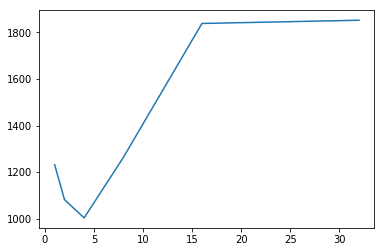

In [22]:
from sklearn.model_selection import cross_val_score
depth = [1, 2, 4, 8, 16, 32]
cvScore = []

for item in depth:
    regressor = DecisionTreeRegressor(random_state = 0, max_depth = item)
    cvScore.append(-(cross_val_score(regressor, X_train, y_train, cv = 5, scoring='neg_mean_squared_error').mean()))

plt.plot(depth, cvScore)

23.40401012158837 1022.8380574907957 0.5358499169663542


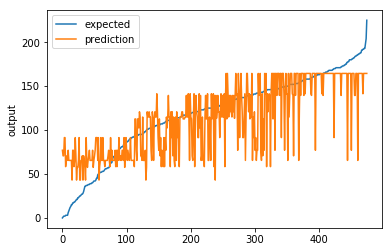

In [23]:
dt = DecisionTreeRegressor(random_state = 0, max_depth = 4)
dt.fit(X_train, y_train)

yHat = dt.predict(X_test)
maeDT = mean_absolute_error(y_test, yHat)
mseDT = mean_squared_error(y_test, yHat)
r2DT = r2_score(y_test, yHat)
print(maeDT, mseDT, r2DT)

chart_regression(yHat.flatten(),y_test.values)

To have a better understanding of this model, I also train a DT with max depth = 20.

29.47051663249032 1782.888474664469 0.19094931255753544


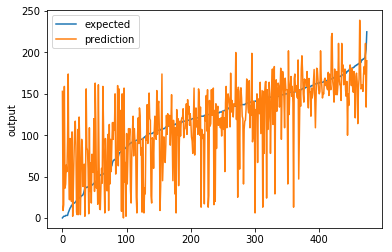

In [24]:
dt = DecisionTreeRegressor(random_state = 0, max_depth = 20)
dt.fit(X_train, y_train)

yHat = dt.predict(X_test)
maeDT = mean_absolute_error(y_test, yHat)
mseDT = mean_squared_error(y_test, yHat)
r2DT = r2_score(y_test, yHat)
print(maeDT, mseDT, r2DT)

chart_regression(yHat.flatten(),y_test.values)

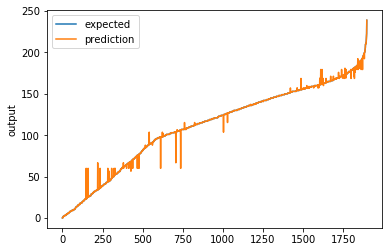

In [25]:
yTrain = dt.predict(X_train)
chart_regression(yTrain.flatten(),y_train.values)

This time our regression tree are able to convey more level of outputs but the range and error are pretty large. If we plot the training regression chart for this 50 level DT, we can find that it is overfitting on the training set too much.

For the next step, I will try to work with some ensemble tree based model like Gradient Boosting Decision Tree (GBDT) and Random Forest(RF).

### 1.1.2 Random Forest

There are two important parameter for us to determine in a RF model:
    
    - The number of trees in the forest
    - The depth of each tree in the forest

In [26]:
from sklearn.ensemble import RandomForestRegressor
numTree = [50, 100, 200]
depth = [1, 2, 4, 8]
#cvScore = float('inf')
cvScore = 0

for d in depth:
    for num in numTree: 
        regressor = RandomForestRegressor(random_state = 42, max_depth = d, n_estimators = num)
        s = (cross_val_score(regressor, X_train, y_train, cv = 5, scoring='r2').mean())
        # print(d, num, s)
        if s > cvScore:
            cvScore = s
            bestDepth = d
            bestNum = num

print(bestDepth, bestNum, cvScore)

4 50 0.6298620405372188


23.162675328703074 1009.7324620643258 0.5417970590000833


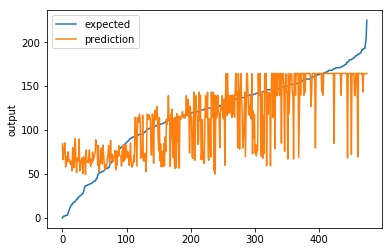

In [28]:
rf = RandomForestRegressor(random_state = 42, max_depth = bestDepth, n_estimators = bestNum)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

chart_regression(yHat.flatten(),y_test.values)

For a forest consist 50 four-layer DTs, this RF has slightly better performance on the test set. This is because we randomly select data and features when building up trees. (This is the reason why RF is not likely to overfitting compare to a single DT.

### 1.1.3 Gradient Boosted Decision Tree
GBDT is combained with number of shallow trees (with max layer number smaller than 3). So here we may only consider the best number of trees.

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
numTree = [25, 50, 100, 200]
#cvScore = float('inf')
cvScore = 0

for num in numTree: 
    regressor = GradientBoostingRegressor(random_state = 42, n_estimators = num)
    s = (cross_val_score(regressor, X_train, y_train, cv = 5, scoring='r2').mean())
    if s > cvScore:
        cvScore = s
        bestNum = num

print(bestNum, cvScore)

50 0.6247894900242537


23.701852631578948 1126.138508631579 0.48897356872797326


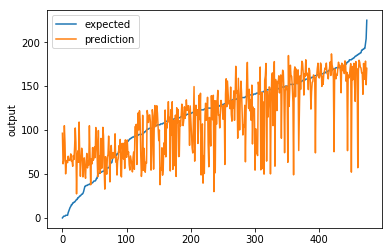

In [32]:
gbdt = RandomForestRegressor(random_state = 42, n_estimators = bestNum)
gbdt.fit(X_train, y_train)

yHat = gbdt.predict(X_test)
maeGBDT = mean_absolute_error(y_test, yHat)
mseGBDT = mean_squared_error(y_test, yHat)
r2GBDT = r2_score(y_test, yHat)
print(maeGBDT, mseGBDT, r2GBDT)

chart_regression(yHat.flatten(),y_test.values)

### 1.2 Regression models

26.94401537198186 1194.7883292148838 0.4578212082045944


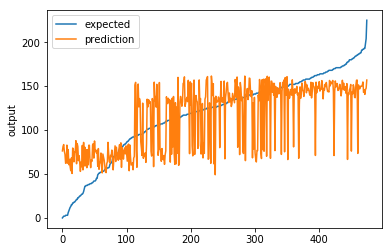

In [54]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train, y_train)

yHat = lin.predict(X_test)
maeLin = mean_absolute_error(y_test, yHat)
mseLin = mean_squared_error(y_test, yHat)
r2Lin = r2_score(y_test, yHat)
print(maeLin, mseLin, r2Lin)

chart_regression(yHat.flatten(),y_test.values)

### 1.3 Neural Networks
There should be a more careful process to determine the structure of the NN. But I will only show 2 here due to the limited time given.

In [58]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Dense(20, input_dim=X.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
# model.fit(X_train, y_train,validation_data=(X_test,y_test),verbose=0,epochs=500)
model.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=500)
model.load_weights('best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
yHat = model.predict(X_test)
maeNN = mean_absolute_error(y_test, yHat)
mseNN = mean_squared_error(y_test, yHat)
r2NN = r2_score(y_test, yHat)
print(maeNN, mseNN, r2NN)

Epoch 00020: early stopping
37.26854448820415 2179.4306363295595 0.011003840334187331


In [60]:
model = Sequential()
model.add(Dense(40, input_dim=X.shape[1], activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(loss='neg_mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
# mpdel.fit(X_train, y_train,validation_data=(X_test,y_test),verbose=0,epochs=500)
model.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=500)
model.load_weights('best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
yHat = model.predict(X_test)
maeNN = mean_absolute_error(y_test, yHat)
mseNN = mean_squared_error(y_test, yHat)
r2NN = r2_score(y_test, yHat)
print(maeNN, mseNN, r2NN)

Epoch 00115: early stopping
28.02956448203639 1214.0720570602548 0.44907051319957625


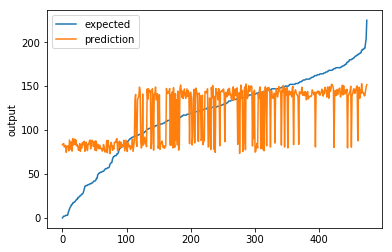

In [61]:
chart_regression(yHat.flatten(),y_test.values)

In this part, I tried several regression method on the whole dataset.

The result could be shown in the following table:

| \ | Mean Absolute Error | Mean Squared Error | R2 Score |
| ------ | ------ | ------ | ------ |
| DT | 23.404 | 1022.838 | 0.536 |
| RF | **23.163** | **1009.732** | **0.542** |
| GBDT | 23.702 | 1126.139 | 0.489 |
| LinReg | 26.944 | 1194.788 | 0.458 |
| NN | 28.030 | 1214.072 | 0.449 | 

I do expected to gain a better performance on the NN model. This result might limit by the bad structure of the network.

As shown in the regression charts, the **cloud.indicator** seems to be too strong for a model to make a acceptable predition result.

So for the next step we will try to work with the splited data for cloudy and clear days on their own.

## 2 Modeling on clear days

### 2.0 Dataset Preparation

  Split into train/test

In [62]:
X = pd.DataFrame(clearDF, columns = ['Y', 'M', 'D', 'weather', 'day.of.week-Friday', 'day.of.week-Monday', 'day.of.week-Saturday', 'day.of.week-Sunday', 'day.of.week-Thursday', 'day.of.week-Tuesday', 'day.of.week-Wednesday'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, clearDF['car.count'], test_size=0.2, random_state=42)

In [63]:
X_train[0:5]

,Y,M,D,weather,day.of.week-Friday,day.of.week-Monday,day.of.week-Saturday,day.of.week-Sunday,day.of.week-Thursday,day.of.week-Tuesday,day.of.week-Wednesday
1708,2014,09,05,0.2,1,0,0,0,0,0,0
1645,2014,07,04,0.3,1,0,0,0,0,0,0
178,2010,06,28,-0.5,0,1,0,0,0,0,0
1239,2013,05,24,1.9,1,0,0,0,0,0,0
2130,2015,11,01,0.2,0,0,0,1,0,0,0


### 2.1 Tree Based Model
#### 2.1.1 Single Decision Tree

Text(0.5,0,'min samples in leaf(log scale)')

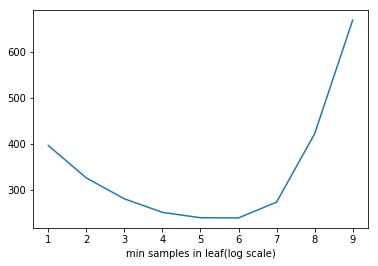

In [64]:
from sklearn.model_selection import cross_val_score
minLeaf = [i for i in range(1, 10)]
cvScore = []

for item in minLeaf:
    regressor = DecisionTreeRegressor(random_state = 0, min_samples_leaf = 2 ** item )
    cvScore.append(-(cross_val_score(regressor, X_train, y_train, cv = 10, scoring='neg_mean_squared_error').mean()))

plt.plot(minLeaf, cvScore)
plt.xlabel('min samples in leaf(log scale)')

In [84]:
model = DecisionTreeRegressor(min_samples_leaf = 2 ** 5)
model.fit(X_train, y_train)

yHat = model.predict(X_test)
maeDT = mean_absolute_error(y_test, yHat)
mseDT = mean_squared_error(y_test, yHat)
r2DT = r2_score(y_test, yHat)
print(maeDT, mseDT, r2DT)

tree.export_graphviz(model, out_file='treeClear.dot', feature_names = X.columns) 
call(['dot','-Tpng','treeClear.dot','-o','treeClear.png'], shell=True)

12.910773272964793 278.2759283085647 0.6135000854078592


0

![title](treeClear.png)

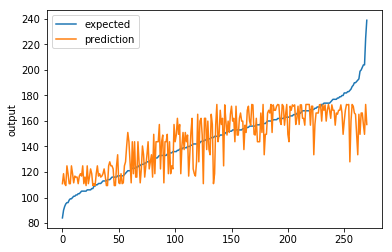

In [85]:
chart_regression(yHat.flatten(),y_test.values)

#### 2.1.2 RF

4 50 0.6505523739954413
12.231422802288577 259.08641081499866 0.6401525771178271


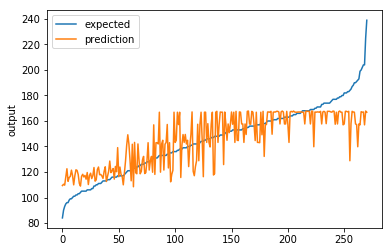

In [86]:
numTree = [50, 100, 200]
depth = [1, 2, 4, 8]
#cvScore = float('inf')
cvScore = 0

for d in depth:
    for num in numTree: 
        regressor = RandomForestRegressor(random_state = 42, max_depth = d, n_estimators = num)
        s = (cross_val_score(regressor, X_train, y_train, cv = 5, scoring='r2').mean())
        # print(d, num, s)
        if s > cvScore:
            cvScore = s
            bestDepth = d
            bestNum = num

print(bestDepth, bestNum, cvScore)

rf = RandomForestRegressor(random_state = 42, max_depth = bestDepth, n_estimators = bestNum)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

chart_regression(yHat.flatten(),y_test.values)

As shown in the regression charts, the tree based models do have some expression ability on the data set, especially for those values close to the average.

### 2.2 Linear Regression

19.623509174961725 617.7307932136556 0.14202820104053882


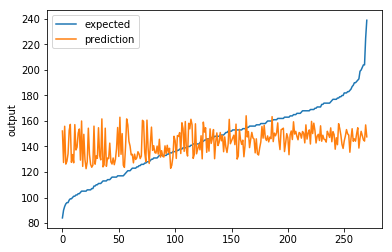

In [87]:
lin = LinearRegression()
lin.fit(X_train, y_train)

yHat = lin.predict(X_test)
maeLin = mean_absolute_error(y_test, yHat)
mseLin = mean_squared_error(y_test, yHat)
r2Lin = r2_score(y_test, yHat)
print(maeLin, mseLin, r2Lin)

chart_regression(yHat.flatten(),y_test.values)

### 2.3 NN

Epoch 00009: early stopping
22.15244290397616 718.7672789825317 0.001697726328907856


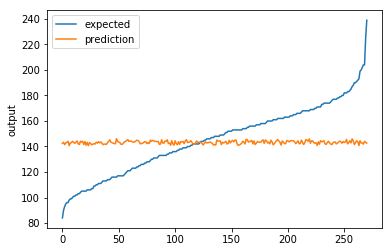

In [88]:
model = Sequential()
model.add(Dense(40, input_dim=X.shape[1], activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model
# mpdel.fit(X_train, y_train,validation_data=(X_test,y_test),verbose=0,epochs=500)
model.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=500)
model.load_weights('best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
yHat = model.predict(X_test)
maeNN = mean_absolute_error(y_test, yHat)
mseNN = mean_squared_error(y_test, yHat)
r2NN = r2_score(y_test, yHat)
print(maeNN, mseNN, r2NN)

chart_regression(yHat.flatten(),y_test.values)

Compare to the tree based models, linear regression model and NN are bumping back and forth in a small range around the average car count for clear days.

| \ | Mean Absolute Error | Mean Squared Error | R2 Score |
| ------ | ------ | ------ | ------ |
| DT | 12.911 | 278.276 | 0.614 |
| RF | **12.231** | **259.086** | **0.640** |
| LinReg | 19.623 | 617.731 | 0.142 |
| NN | 22.152 | 718.767 | 0.002 |



## 3 Modeling on cloudy days

### 3.0 Dataset Preparation

  Split into train/test

In [89]:
X = pd.DataFrame(cloudDF, columns = ['Y', 'M', 'D', 'weather', 'day.of.week-Friday', 'day.of.week-Monday', 'day.of.week-Saturday', 'day.of.week-Sunday', 'day.of.week-Thursday', 'day.of.week-Tuesday', 'day.of.week-Wednesday'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, cloudDF['car.count'], test_size=0.2, random_state=42)

### 3.1 Model Fitting
    - Single DT
    - RF
    - Linear regression

Text(0.5,0,'min samples in leaf(log scale)')

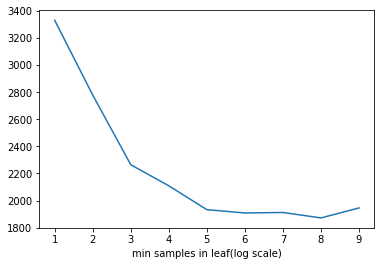

In [90]:
from sklearn.model_selection import cross_val_score
minLeaf = [i for i in range(1, 10)]
cvScore = []

for item in minLeaf:
    regressor = DecisionTreeRegressor(random_state = 0, min_samples_leaf = 2 ** item )
    cvScore.append(-(cross_val_score(regressor, X_train, y_train, cv = 10, scoring='neg_mean_squared_error').mean()))

plt.plot(minLeaf, cvScore)
plt.xlabel('min samples in leaf(log scale)')

38.11289212015605 1995.5364208743745 0.0457543871532442


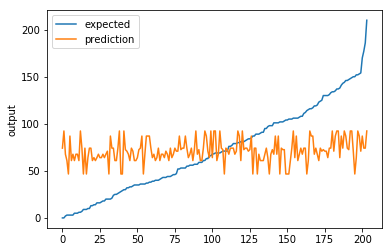

In [92]:
model = DecisionTreeRegressor(min_samples_leaf = 2 ** 6)
model.fit(X_train, y_train)

yHat = model.predict(X_test)
maeDT = mean_absolute_error(y_test, yHat)
mseDT = mean_squared_error(y_test, yHat)
r2DT = r2_score(y_test, yHat)
print(maeDT, mseDT, r2DT)

tree.export_graphviz(model, out_file='treeCloud.dot', feature_names = X.columns) 
call(['dot','-Tpng','treeCloud.dot','-o','treeCloud.png'], shell=True)

chart_regression(yHat.flatten(),y_test.values)

1 100 0.026627266276681237
38.27410735150952 2043.2836114639667 0.02292215684701282


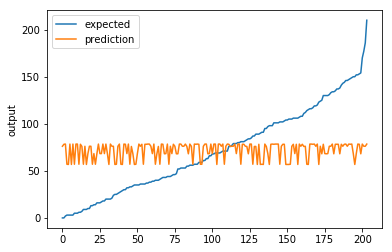

In [93]:
numTree = [50, 100, 200]
depth = [1, 2, 4, 8]
#cvScore = float('inf')
cvScore = 0

for d in depth:
    for num in numTree: 
        regressor = RandomForestRegressor(random_state = 42, max_depth = d, n_estimators = num)
        s = (cross_val_score(regressor, X_train, y_train, cv = 5, scoring='r2').mean())
        # print(d, num, s)
        if s > cvScore:
            cvScore = s
            bestDepth = d
            bestNum = num

print(bestDepth, bestNum, cvScore)

rf = RandomForestRegressor(random_state = 42, max_depth = bestDepth, n_estimators = bestNum)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

chart_regression(yHat.flatten(),y_test.values)

39.73648082412939 2174.207791920503 -0.03968448040066286


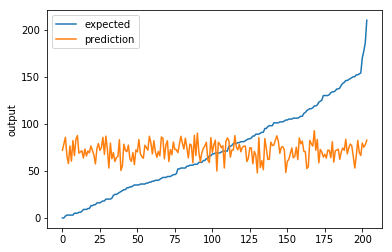

In [94]:
lin = LinearRegression()
lin.fit(X_train, y_train)

yHat = lin.predict(X_test)
maeLin = mean_absolute_error(y_test, yHat)
mseLin = mean_squared_error(y_test, yHat)
r2Lin = r2_score(y_test, yHat)
print(maeLin, mseLin, r2Lin)

chart_regression(yHat.flatten(),y_test.values)

As what we found in the data exploration section, the cloudy data are more noisy and difficult to predict.

## 4 Predict future car count

To predict the future car count, we may not consider the date (especially for the year number) in the training process.

As we have find that RF have better performance on the dataset, we will keep working with it.

In [107]:
X = pd.DataFrame(df, columns = ['M', 'D', 'weather', 'day.of.week-Friday', 'day.of.week-Monday', 'day.of.week-Saturday', 'day.of.week-Sunday', 'day.of.week-Thursday', 'day.of.week-Tuesday', 'day.of.week-Wednesday', 'cloud.indicator'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, df['car.count'], test_size=0.2, random_state=42)

28.52058930778263 1264.2329162801375 0.4263081933959282


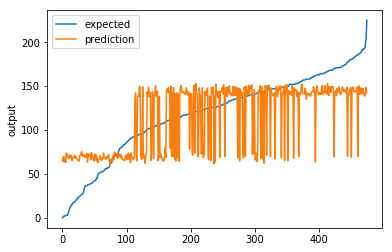

In [108]:
rf = RandomForestRegressor(random_state = 42, max_depth = 4, n_estimators = 50)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

chart_regression(yHat.flatten(),y_test.values)

In [112]:
X = pd.DataFrame(df, columns = ['D', 'weather', 'cloud.indicator'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, df['car.count'], test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state = 42, max_depth = 4, n_estimators = 50)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

28.576550172767682 1270.2887100326823 0.42356015605757014


In [99]:
X = pd.DataFrame(df, columns = ['M', 'weather', 'day.of.week-Friday', 'day.of.week-Monday', 'day.of.week-Saturday', 'day.of.week-Sunday', 'day.of.week-Thursday', 'day.of.week-Tuesday', 'day.of.week-Wednesday', 'cloud.indicator'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, df['car.count'], test_size=0.2, random_state=42)

28.54041429506278 1261.4925201447504 0.427551748115534


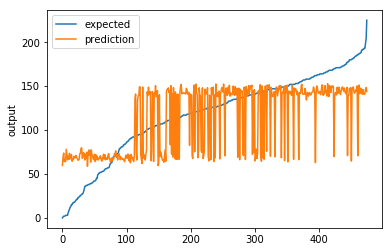

In [102]:
rf = RandomForestRegressor(random_state = 42, max_depth = 4, n_estimators = 50)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

chart_regression(yHat.flatten(),y_test.values)

28.64810128794856 1274.462871310529 0.421665978098978


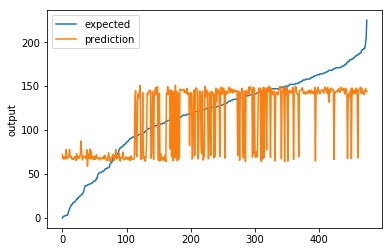

In [103]:
X = pd.DataFrame(df, columns = ['weather', 'day.of.week-Friday', 'day.of.week-Monday', 'day.of.week-Saturday', 'day.of.week-Sunday', 'day.of.week-Thursday', 'day.of.week-Tuesday', 'day.of.week-Wednesday', 'cloud.indicator'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, df['car.count'], test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state = 42, max_depth = 4, n_estimators = 50)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

chart_regression(yHat.flatten(),y_test.values)

In [111]:
X = pd.DataFrame(df, columns = ['weather', 'cloud.indicator'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, df['car.count'], test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state = 42, max_depth = 4, n_estimators = 50)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

28.685520326849502 1277.1929654749824 0.42042709827451263


In [113]:
X = pd.DataFrame(df, columns = ['M', 'D', 'weather', 'cloud.indicator'])
# X = pd.DataFrame(df, columns = ['M', 'D', 'weather','day.of.week', 'cloud.indicator'])

X_train, X_test, y_train, y_test = train_test_split(X, df['car.count'], test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state = 42, max_depth = 4, n_estimators = 50)
rf.fit(X_train, y_train)

yHat = rf.predict(X_test)
maeRF = mean_absolute_error(y_test, yHat)
mseRF = mean_squared_error(y_test, yHat)
r2RF = r2_score(y_test, yHat)
print(maeRF, mseRF, r2RF)

28.48986488860815 1263.6055388343239 0.42659288879950186


| Month | Date | weather | day of week | cloud.indicator | MAE | MSE | R2 |
| -- | -- | -- | -- | -- | -- | -- | -- |
| T | T | T | T | T | 28.521 | 1264.233 | 0.426 | 
|   | T | T | T | T | 28.576 | 1270.289 | 0.424 | 
| T |   | T | T | T | 28.540 | **1261.493** | **0.428** | 
|   |   | T | T | T | 28.648 | 1274.463 | 0.422 | 
| T | T | T |   | T | **28.490** | 1263.606 | 0.427 | 
|   |   | T |   | T | 28.685 | 1277.193 | 0.420 | 

The result is consistent with what has found previously. The performance is not very good and relable.

The data set is not very large, and noisy, and it seems no clear pattern in that.

**small dataset**

If we want to predict the car num for a certain day in the future, the data set could only provide 6 or 7 data for us to reference. This could be an important factor of the bad prediction result.

**noisy data**

As shown in the plots above, the car.count for cloudy days are ~50% of the number of cars in clear days on average. But consider the different condition of the blocking effects, the count of cloudy days have larger variation. This will made the model unstable.

## 5. Future improvements

-   Further understanding of the features like the meaning of the weather value may provide new ideas about how should we build and optimize a model
-   More data could be involved
-   We may first deal with the noisy data by removing outlayers or try to recover the 'actual' car count for cloudy days
-   Based on a better data preprocessing and feature engineering, 
    some time series analysis methods like: **Autoregressive Integrated Moving Average (ARIMA) model** and **Long Short Term Memory(LSTM) Network** could be employed to predict the count in the future.

In [114]:
pct

0.4978943010312869